# Hurricane Matthew Keyword Collection Analysis

In [5]:
import json, sys, datetime
import pandas as pd; import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Load all of the tweets into a single dataframe
# df = pd.read_json('/data/chime/matthew/keyword_tweets.json')

In [7]:
# x = df.head(10000)
# len(df)

In [8]:
# For simplicity, let's do what you should never do and iterate over the dataframe and create a jsonl file:
# length = len(df)
# with open('/data/chime/matthew/keyword_tweets.jsonl','w') as oFile:
#     for index, row in df.iterrows():
#         oFile.write(row.to_json()+"\n")
#         if index%100==0:
#             sys.stderr.write("\r{0:2.2f} % ".format(index/length*100))

First, Identify tweets that inclue the following location based terms:

    Brunswick
    Savanah
    Charleston
    Tybee (Island)

This is actually best done with `grep`. Run the following code block in the directory

```bash
grep -i "brunswick"  keyword_tweets.jsonl > locations/brunswick.jsonl && 
grep -i "savannah"   keyword_tweets.jsonl > locations/savannah.jsonl && 
grep -i "charleston" keyword_tweets.jsonl > locations/charleston.jsonl && 
grep -i "tybee"      keyword_tweets.jsonl > locations/tybee.jsonl
```

# Basic analysis for each of these subfiles

In [9]:
def read_place(place):
    tweets = []
    with open("/data/chime/matthew/locations/"+place+".jsonl") as inFile:
        for line in inFile:
            obj = json.loads(line)
            tweets.append(obj)
    df = pd.DataFrame(tweets)
    df['datetime'] = df.created_at.apply(lambda x: pd.Timestamp(x*1000000))
    df['hour'] = df.datetime.apply(lambda t: datetime.datetime(t.year, t.month, t.day, t.hour))
    gb_hour = df.groupby('hour')
    agged = gb_hour.agg({'user_screen_name':{
                          'Unique Users': pd.Series.nunique,
                          'Tweet Count' : pd.Series.count
                        },
                     'tweet_type': {
                        'posts'  : lambda x: sum(x=='post'),
                        'rewteets' : lambda x: sum(x=='share'),
                        }
                    })
    return df, agged

In [10]:
def summary_stats(df):
    return "{0} tweets from {1} unique users".format(len(df), pd.Series.nunique(df.user_screen_name))

In [11]:
places = [
    {'name':'savannah'},
    {'name': 'brunswick'},
    {'name': 'tybee'},
    {'name': 'charleston'}
]

In [12]:
for p in places[:1]:
    p['df'], p['agged'] = read_place(p['name'])

/usr/local/lib/python3.5/dist-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


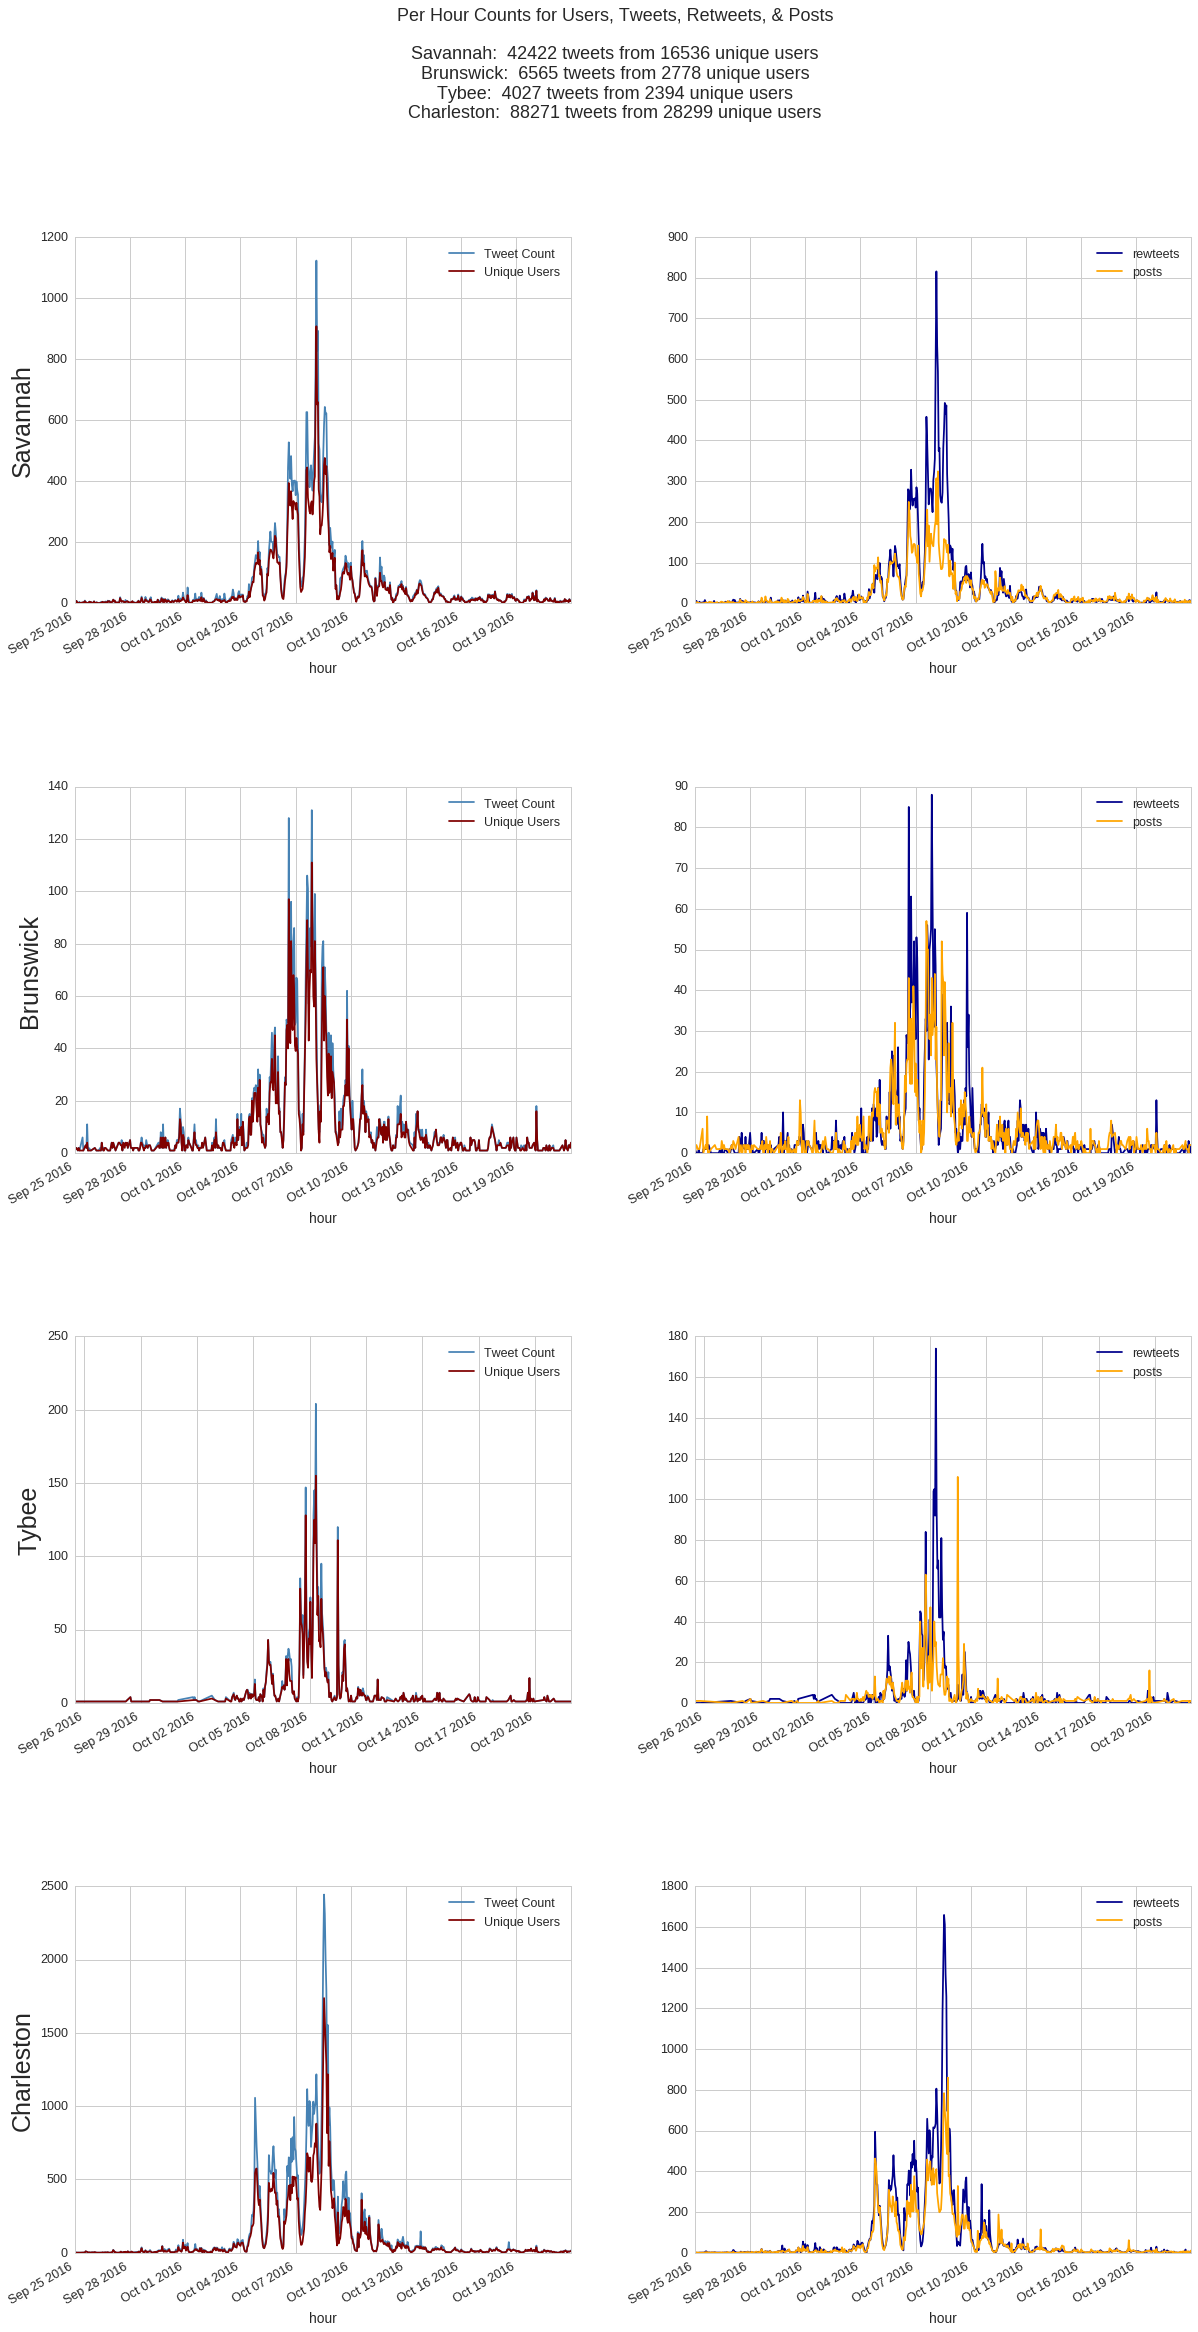

In [13]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20,40), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.25, hspace=0.5)

axes = axs.ravel()

for idx, p in enumerate(places):
    ax = axes[idx*2]

    p['agged']['user_screen_name'].plot(ax=ax, color=['steelblue','maroon'] )

    ax.set_ylabel(p['name'].capitalize(), fontsize=25)
 
    ax2 = axes[idx*2+1]
    p['agged']['tweet_type'].plot(ax=ax2, color=['darkblue','orange'])
    
plt.suptitle("Per Hour Counts for Users, Tweets, Retweets, & Posts\n\n{0}".format(
        "\n".join([p['name'].capitalize() + ":  " + summary_stats(p['df']) for p in places])
        ),fontsize=18)

## Export CSVs

In [14]:
for p in places[:1]:
    to_export = p['df'][['datetime','user_name','user_screen_name','text','user_location','tweet_type']].sort_values(by='datetime')
    print(p['name'], len(to_export))
#     with open('/data/chime/matthew/locations/'+p['name']+'.csv','w') as oFile: 
#         to_export.to_csv(oFile, index=False)

savannah 42422


In [15]:
places[0]['df'].head()

,created_at,followers,friends,geolocation,id,original_text,text,tweet_type,user_location,user_name,user_screen_name,verified,datetime,hour
0,1476483148000,80,236,None,787053484768161792,None,In a world price gouging #HurricaneMatthew vic...,post,savannah GA,Rachel Greiner,rachelmbutler,False,2016-10-14 22:12:28,2016-10-14 22:00:00
1,1476519317000,358,344,None,787205188507631616,I am with you always. -Matthew 28.20,RT @Bible_Time: I am with you always. -Matthew...,share,papo,SavannahDemetro🙄,justnana16,False,2016-10-15 08:15:17,2016-10-15 08:00:00
2,1476519566000,1723,1151,None,787206234613149696,Apparently H is in Jamaica. L is with him or h...,RT @LarryNextToYou: Apparently H is in Jamaica...,share,in love with Louis' eyes,savannah,luvmylittleboo,False,2016-10-15 08:19:26,2016-10-15 08:00:00
3,1476803596000,30503,293,None,788397543868604416,None,Apartment Complex Residents Left High and Dry ...,post,"Savannah, GA / Hilton Head, SC",WSAV News 3,WSAV,False,2016-10-18 15:13:16,2016-10-18 15:00:00
4,1476803768000,2495,2640,None,788398265205198848,Patrick Murphy busted lying again at #FLSenDeb...,RT @BurgosGOP: Patrick Murphy busted lying aga...,share,"Savannah, GA",(((GAGirl1967 LP))),Tamaraw68415067,False,2016-10-18 15:16:08,2016-10-18 15:00:00


# Cleaning up the Brunswick Tweets

In [55]:
brunswick = places[1]['df']
len(brunswick)

6565

In [56]:
brunswick = brunswick.fillna(value="")

In [57]:
brunswick.user_location.value_counts().head(10)

Brunswick, GA                 822
                              606
New Brunswick, Canada         348
New Brunswick, New Jersey     311
New Brunswick, NJ             277
North Brunswick, NJ           199
Brunswick, Ga                 153
Atlanta, GA                   149
Fredericton, New Brunswick    111
Saint John, New Brunswick     100
Name: user_location, dtype: int64

In [59]:
brunswick_filterOne = brunswick[~brunswick.user_location.str.contains(r'(maine|canada|can|nj|jersey|virginia|.*New Brunswick|New|Nouveau.\s*Brunswick|NC|OH|NY|MA|ME|DC|CO|MD|WA|CA|CO|FL|NV|TX)',case=False)]

-c:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [60]:
len(brunswick_filterOne)

3079

In [61]:
brunswick_filterOne.user_location.value_counts().head()

Brunswick, GA         822
                      606
Brunswick, Ga         153
Atlanta, GA           149
Brunswick, Georgia     96
Name: user_location, dtype: int64

In [62]:
brunswick_filtered = brunswick[brunswick.user_location.str.contains(r'brunswick.*(ga|georgia)',case=False)]

-c:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [63]:
len(brunswick_filtered)

1341

In [148]:
to_export = brunswick_filtered[['datetime','user_name','user_screen_name','text','user_location','tweet_type']].sort_values(by='datetime')
with open('/data/www/chime/just_brunswick.csv','w') as oFile: 
    to_export.to_csv(oFile, index=False)

# Filter for Savannah?

In [28]:
for p in places:
    print(p['name'], len(p['df']))

savannah 42422
brunswick 6565
tybee 4027
charleston 88271


In [21]:
sav = places[0]['df']
sav = sav.fillna(value="")

In [22]:
sav.user_location.value_counts().head()

Savannah, GA         12118
                      7104
Savannah, Georgia      968
Savannah, GA           729
Atlanta, GA            636
Name: user_location, dtype: int64

In [23]:
sav_filtered = sav[sav.user_location.str.contains(r'savannah.*(ga|georgia)',case=False)]

-c:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [24]:
len(sav_filtered)

17816

In [26]:
sav_filtered.user_location.value_counts().head()

Savannah, GA                      12118
Savannah, Georgia                   968
Savannah, GA                        729
Savannah, GA / Hilton Head, SC      440
WSAV News 3 Savannah, GA            300
Name: user_location, dtype: int64

In [39]:
with open('/data/www/chime/just_savannah.csv','w') as oFile: 
    sav_filtered[['datetime','user_name','user_screen_name','text','user_location','tweet_type']].sort_values(by='datetime').to_csv(oFile, index=False)

# Filter for Tybee?

In [40]:
for p in places:
    print(p['name'], len(p['df']))

savannah 42422
brunswick 6565
tybee 4027
charleston 88271


In [41]:
tybee = places[2]['df']
tybee = tybee.fillna(value="")

In [42]:
tybee.user_location.value_counts().head()

                    893
Savannah, GA        304
Atlanta, GA         153
Tybee Island, GA    111
Ky and Ga.           49
Name: user_location, dtype: int64

In [43]:
tybee_filtered = tybee[tybee.user_location.str.contains(r'.*tybee.*',case=False)]

In [44]:
len(tybee_filtered)

293

In [45]:
tybee_filtered.user_location.value_counts().head()

Tybee Island, GA         111
Tybee Island, GA USA      32
Tybee Island, GA, USA     22
Tybee Island, Georgia     19
Tybee                     15
Name: user_location, dtype: int64

In [46]:
with open('/data/www/chime/just_tybee.csv','w') as oFile: 
    tybee_filtered[['datetime','user_name','user_screen_name','text','user_location','tweet_type']].sort_values(by='datetime').to_csv(oFile, index=False)

# Filter for Charleston?

In [47]:
for p in places:
    print(p['name'], len(p['df']))

savannah 42422
brunswick 6565
tybee 4027
charleston 88271


In [48]:
char = places[3]['df']
char = char.fillna(value="")

In [49]:
char.user_location.value_counts().head()

Charleston, SC                33900
                              10264
Charleston, South Carolina     2082
North Charleston, SC           1683
Charleston, WV                 1071
Name: user_location, dtype: int64

In [50]:
char_filtered = char[char.user_location.str.contains(r'charleston.*(sc|south\s*carolina|carolina).*',case=False)]

-c:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [51]:
len(char_filtered)

44170

In [52]:
char_filtered.user_location.value_counts().head()

Charleston, SC                33900
Charleston, South Carolina     2082
North Charleston, SC           1683
Charleston, SC                  935
Charleston SC                   675
Name: user_location, dtype: int64

In [53]:
with open('/data/www/chime/just_charleston.csv','w') as oFile: 
    char_filtered[['datetime','user_name','user_screen_name','text','user_location','tweet_type']].sort_values(by='datetime').to_csv(oFile, index=False)

# Beaufort, SC

In [6]:
df, agged = read_place('beaufort')

In [8]:
df.count()

created_at          6779
followers           6779
friends             6779
geolocation          240
id                  6779
original_text       3961
text                6779
tweet_type          6779
user_location       5734
user_name           6779
user_screen_name    6779
verified            6779
datetime            6779
hour                6779
dtype: int64

In [10]:
df = df.fillna(value="")

In [11]:
beau_filtered = df[df.user_location.str.contains(r'beaufort.*(sc|south\s*carolina|carolina).*',case=False)]

-c:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [12]:
with open('/data/www/chime/just_beaufort.csv','w') as oFile: 
    beau_filtered[['datetime','user_name','user_screen_name','text','user_location','tweet_type']].sort_values(by='datetime').to_csv(oFile, index=False)

In [13]:
len(beau_filtered)

1236